In [41]:
%load_ext autoreload
%autoreload 2

In [42]:
from utils import load_confpred, load_dataset, load_results, summarize_folders
from matplotlib import pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.family": "mathpazo"})

import os
import glob
from torch.utils.data import Subset
import seaborn as sns
import pandas as pd
from experiments.regression_utils import process_pacbayes, process_confpred, process_learnable, apply_filters, Filter

ModuleNotFoundError: No module named 'experiments'

In [43]:
RESULTS_ROOT = "results/toy/"
FIGURES_ROOT = "figures/toy/"
os.makedirs(FIGURES_ROOT, exist_ok=True)

In [44]:
results = summarize_folders(glob.glob(os.path.join(RESULTS_ROOT, "*/")))

In [45]:
filtered_data = apply_filters(
    pd.concat(
        [
            process_learnable(results),
            process_pacbayes(results),
            process_confpred(results),
        ]
    ),
    [Filter("seed", lambda x: x == 2026)],
).set_index(["calibrate.name", "data.split.val.N"])

Holding 500 datapoints for prior optimization.
Keeping 500 datapoints for calibration.


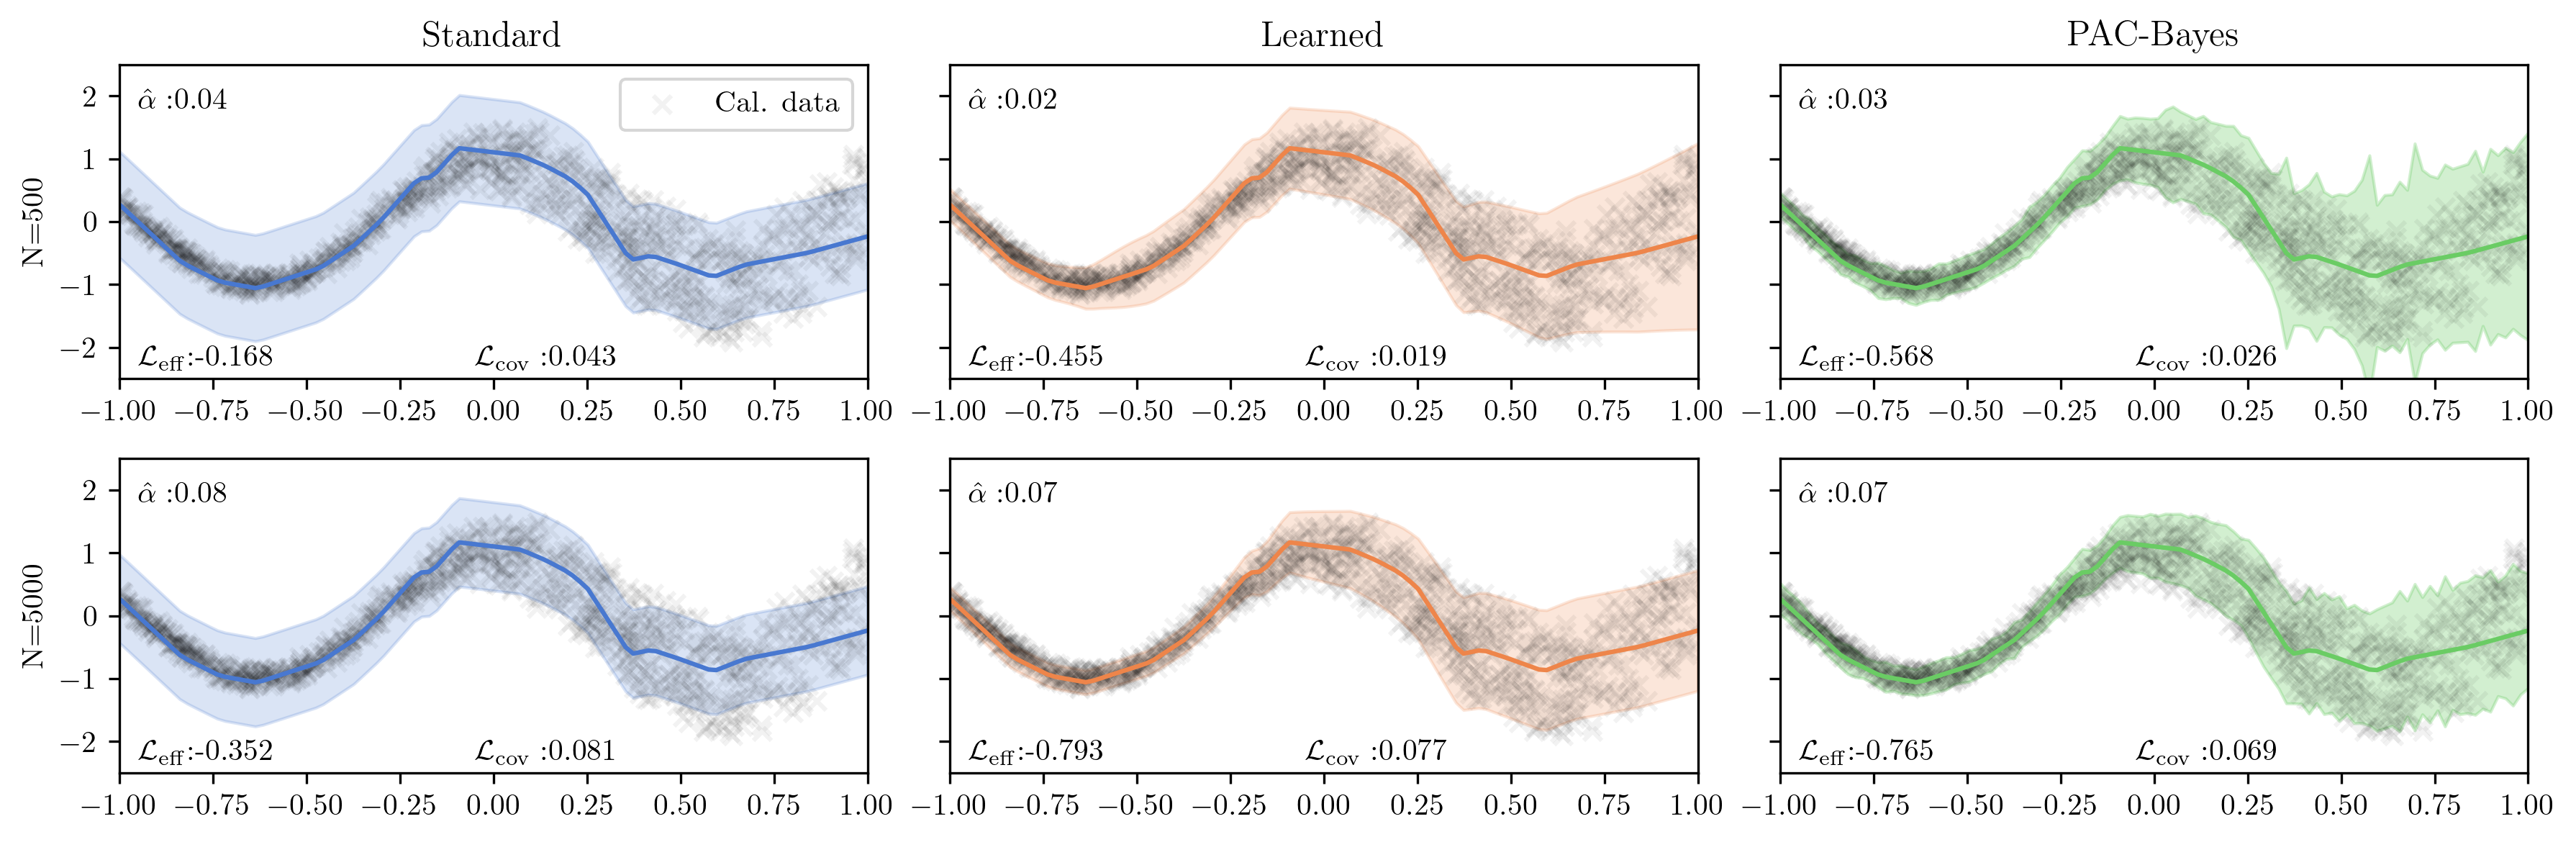

In [46]:
Ns = [500,5000]
names = ["confpred","learnable","pacbayes"]

dataset = load_dataset("models/toy/calibrate.alpha_hat=-1,calibrate.prior_split=0.5,calibrate=learnable,data.split.val.N=1000,seed=2026/", split="val")
if isinstance(dataset, Subset):
    dataset = dataset.dataset
fig,axes = plt.subplots(len(Ns), len(names), sharey="row", figsize=[12,4], dpi=300)
for i,(N) in enumerate(Ns):
    titles = [
        "Standard", "Learned", "PAC-Bayes"
    ]
    colors = sns.color_palette("muted",3)
    for j in range(3):
        df = filtered_data.loc[names[j], N]
        confpred = load_confpred("models/" + "/".join(df["filename"].split("/")[1:]))
        dataset.plot_predictions(axes[i,j], confpred, color=colors[j])
        axes[0,j].set_title(titles[j])
        alpha_hat = (1-df['posterior.coverage']).item()
        axes[i,j].text(-0.95,1.8, r"$\hat{\alpha}:$"f"{alpha_hat:0.02f}")
        axes[i,j].text(-0.05,-2.3, r"$\mathcal{L}_\mathrm{cov}:$"f"{1-df['test.coverage'].item():0.03f}")
        axes[i,j].text(-0.95,-2.3, r"$\mathcal{L}_\mathrm{eff}$:"f"{df['test.set_size'].item():0.03f}")
    axes[i,0].set_ylabel(f"{N=}")
    axes[0,0].legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_ROOT,"illustrative_ex.pdf"))
plt.show()